# testing data augmentation methods

In [93]:
import tensorflow.keras as kr
import numpy as np 
import matplotlib.pyplot as plt
import cv2

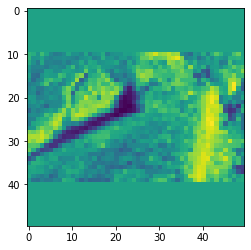

In [9]:
# load data
dat = np.load("/local/ecw/deepscribe-data/pfa/a_pfa_resized_50_0_0_False_top50.npz")
X_train = dat["train_imgs"]
plt.imshow(X_train[1,:,:,0])

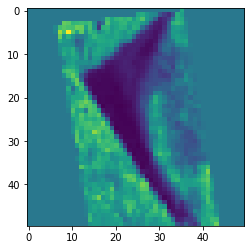

In [10]:
data_gen = kr.preprocessing.image.ImageDataGenerator(
    shear_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=15,
    fill_mode="constant",
    cval=0.0
)
batch = next(data_gen.flow(X_train, shuffle=False))
plt.imshow(batch[0,:,:,0])

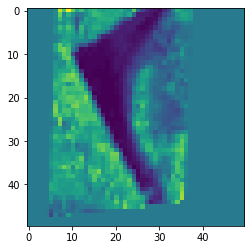

In [67]:
data_gen = kr.preprocessing.image.ImageDataGenerator(
    shear_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=15,
    fill_mode="constant",
    brightness_range=[0.0, 1.0],
    cval=0.0
)
batch = next(data_gen.flow(X_train, shuffle=False))
plt.imshow(batch[0,:,:,0])

In [68]:
def hist_norm(x, bin_edges, quantiles, inplace=False):
    """
    Linearly transforms the histogram of an image such that the pixel values
    specified in `bin_edges` are mapped to the corresponding set of `quantiles`

    Arguments:
    -----------
        x: np.ndarray
            Input image; the histogram is computed over the flattened array
        bin_edges: array-like
            Pixel values; must be monotonically increasing
        quantiles: array-like
            Corresponding quantiles between 0 and 1. Must have same length as
            bin_edges, and must be monotonically increasing
        inplace: bool
            If True, x is modified in place (faster/more memory-efficient)

    Returns:
    -----------
        x_normed: np.ndarray
            The normalized array
    """

    bin_edges = np.atleast_1d(bin_edges)
    quantiles = np.atleast_1d(quantiles)

    if bin_edges.shape[0] != quantiles.shape[0]:
        raise ValueError('# bin edges does not match number of quantiles')

    if not inplace:
        x = x.copy()
    oldshape = x.shape
    pix = x.ravel()

    # get the set of unique pixel values, the corresponding indices for each
    # unique value, and the counts for each unique value
    pix_vals, bin_idx, counts = np.unique(pix, return_inverse=True,
                                          return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution function (which maps pixel
    # values to quantiles)
    ecdf = np.cumsum(counts).astype(np.float64)
    ecdf /= ecdf[-1]

    # get the current pixel value corresponding to each quantile
    curr_edges = pix_vals[ecdf.searchsorted(quantiles)]

    # how much do we need to add/subtract to map the current values to the
    # desired values for each quantile?
    diff = bin_edges - curr_edges

    # interpolate linearly across the bin edges to get the delta for each pixel
    # value within each bin
    pix_delta = np.interp(pix_vals, curr_edges, diff)

    # add these deltas to the corresponding pixel values
    pix += pix_delta[bin_idx]

    return pix.reshape(oldshape)

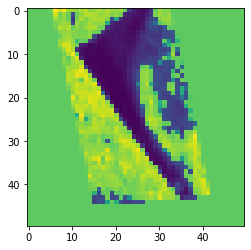

In [74]:
data_gen = kr.preprocessing.image.ImageDataGenerator(
    shear_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=15,
    fill_mode="constant",
    cval=0.0
)
batch = next(data_gen.flow(X_train, shuffle=False))
img = batch[0,:,:,0]

bin_edges = -1, -0.5, 0.5, 1.0
quantiles = 0, 0.2, 0.5, 1.0
normed = hist_norm(img, bin_edges, quantiles)
plt.imshow(normed)

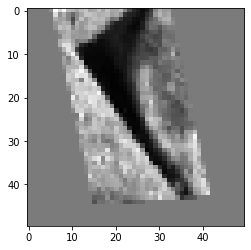

In [166]:
plt.imshow(img, cmap="gray")

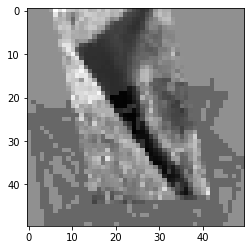

In [176]:
mask = np.zeros_like(img) 

def generate_shadow_coordinates(imshape, no_of_shadows=1):    
    vertices_list=[]    
    for index in range(no_of_shadows):        
        vertex=[]        
        for dimensions in range(np.random.randint(3,15)): ## Dimensionality of the shadow polygon            
            vertex.append(( imshape[1]*np.random.uniform(),imshape[0]//3+imshape[0]*np.random.uniform()))        
            vertices = np.array([vertex], dtype=np.int32) ## single shadow vertices         
            vertices_list.append(vertices)    
    return vertices_list ## List of shadow vertices

verts = generate_shadow_coordinates(img.shape, no_of_shadows=5)
cv2.fillPoly(mask, verts, np.random.uniform(-2, 0))

augmented_img = img + mask

renormalized = (augmented_img - np.mean(augmented_img)/np.std(augmented_img))

plt.imshow(renormalized,  cmap="gray")

# def add_shadow(image,no_of_shadows=1):    
#     image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) 
#     ## Conversion to HLS    
#     mask = np.zeros_like(image)     
#     imshape = image.shape    
#     vertices_list= generate_shadow_coordinates(imshape, no_of_shadows) 
#     #3 getting list of shadow vertices    
#     for vertices in vertices_list:         
#         cv2.fillPoly(mask, vertices, 255) ## adding all shadow polygons on empty mask, single 255 denotes only red channel        
#         image_HLS[:,:,1][mask[:,:,0]==255] = image_HLS[:,:,1][mask[:,:,0]==255]*0.5   ## if red channel is hot, image's "Lightness" channel's brightness is lowered     
#         image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB    return image_RGB


# verts = generate_shadow_coordinates(img.shape)
# verts

In [189]:
# zero out the parts of the polygon that overlap with the image padding

zero_x, zero_y = np.where(img == 0)
mask[zero_x, zero_y] = 0 

nonzero_x, nonzero_y = np.nonzero(img)

np.std(img[nonzero_x, nonzero_y])

# augmented_img = img + mask

# renormalized = (augmented_img - np.mean(augmented_img)/np.std(augmented_img))
# plt.imshow(renormalized, cmap="gray")



0.90932596